# Plotting

This notebook is insanely messy because each plot is made within its own function, so the code is insanely redundant.
But the purpose of this notebook is purely exploratory, so ... no care given 🙃


In [37]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import squarify
import seaborn as sns

from utils import print_pretty_df

# Quick ANSI color code shortcuts
r = "\033[31m"
y = "\033[33m"
g = "\033[32m"
b = "\033[34m"
e = "\033[0m"

pickleName = "all_datapoints_2024-12-24_11-59-55.pkl"
datapointsDfPath = Path("..") / ".." / "data" / "Review_ML-RS-FPGA" / "Dataframes" / pickleName
datapointsDf = pd.read_pickle(datapointsDfPath)

## Basic 1 dimensional plot

By "1D" it means I don't plot one of the main info against another. I keep it simple: bar plots with counts, or counts against times


### Implementation means


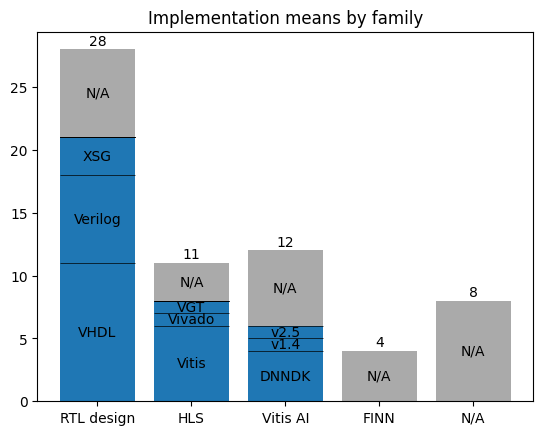

In [22]:
def barPlot_implMeans_perFamily_v1(implementationCounts) -> None:
    # --- Create Pivot Table ---
    # Transform the implementation counts into a DataFrame with categories and subcategories
    listImplCategories = []
    for fullTag, value in implementationCounts.items():
        mainCat = fullTag.split("(")[0].strip()
        subCat = fullTag.split("(")[1][:-1].strip() if "(" in fullTag else "N/A"
        listImplCategories.append([mainCat, subCat, value])

    implDf = pd.DataFrame(listImplCategories, columns=["Category", "SubCategory", "Count"])
    implDf = implDf.sort_values(by=["Count"])

    # Pivot the DataFrame to get the correct format for plotting
    subcatByCatCounts = implDf.pivot(index="Category", columns="SubCategory", values="Count").fillna(0)

    # --- Sort ---
    # Sort the categories: Create a 'Total' column, sort by it then drop it
    subcatByCatCounts["Total"] = subcatByCatCounts.sum(axis=1)
    subcatByCatCounts = subcatByCatCounts.sort_values(by="Total", ascending=False)
    subcatByCatCounts = subcatByCatCounts.drop(columns=["Total"])
    # Sort the catgeories by count and force the 'N/A' category on the right
    if "N/A" in subcatByCatCounts.index:
        new_index = [cat for cat in subcatByCatCounts.index if cat != "N/A"]
        subcatByCatCounts = subcatByCatCounts.reindex(new_index + ["N/A"])

    # Manually sort pivot table columns
    subcatByCatCounts = subcatByCatCounts[
        [
            "VHDL",
            "Verilog",
            "XSG",
            "Vitis",
            # "FINN", # FINN is now a category in itself
            "Vivado",
            "VGT",
            "DNNDK",
            "v1.4",
            "v2.5",
            "N/A",
        ]
    ]

    # --- Setup Plot ---
    categories = subcatByCatCounts.index
    subCategories = subcatByCatCounts.columns
    width = 0.8  # the width of the bars
    xAxisPositions = np.arange(len(categories))

    # --- Plot ---
    fig, ax = plt.subplots()
    bottom = np.zeros(len(categories))

    for i, subCat in enumerate(subCategories):
        counts = subcatByCatCounts[subCat].values
        if subCat == "N/A":
            color = "#aaaaaa"  # Gray for 'N/A'
        else:
            color = "#1f77b4"  # Default matplotlib blue
        p = ax.bar(
            xAxisPositions,
            counts,
            width,
            label=subCat,
            bottom=bottom,
            color=color,
        )
        bottom += counts
        ax.bar_label(
            p,
            labels=[f"{subCat}" if count > 0 else "" for count in counts],
            label_type="center",
        )

    # Set x-axis labels
    ax.set_xticks(xAxisPositions)
    ax.set_xticklabels(categories)

    # Add total count labels on top of each bar
    catTotalCount = subcatByCatCounts.sum(axis=1)
    for i, total in enumerate(catTotalCount):
        ax.text(xAxisPositions[i], total + 0.1, f"{int(total)}", ha="center", va="bottom")

    # Add horizontal lines between sub-categories
    catCumulativeCount = subcatByCatCounts.cumsum(axis=1)
    for idx, category in enumerate(categories):
        lineStart = xAxisPositions[idx] - width / 2
        lineStop = xAxisPositions[idx] + width / 2
        yAxisPosition = catCumulativeCount.loc[category].values
        for y in yAxisPosition[:-1]:  # Exclude the last total yAxisPosition
            if y > 0:
                ax.hlines(y, lineStart, lineStop, colors='black', linewidth=0.5)

    ax.set_title("Implementation means by family")

    plt.show()

barPlot_implMeans_perFamily_v1(datapointsDf["Implementation"].value_counts())

C:\Users\leon_ce\AppData\Local\Temp\ipykernel_5480\3886601662.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['Implementation', 'Publication year']).size().reset_index(name='Count')


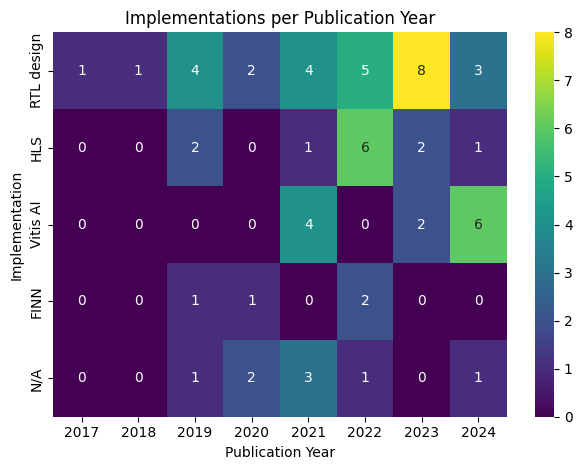

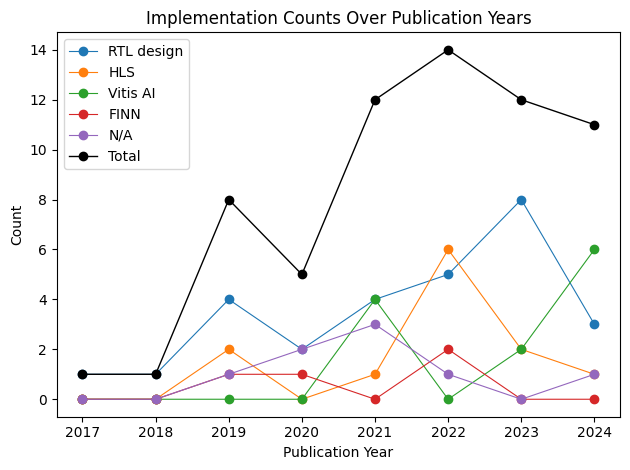

In [31]:
def heatmap_implMeans_perYear_v2(DataFrame, groupedByType=False, linePlot=False):
    """
    Plot a heatmap showing the counts of Implementations per Publication Year.
    When 'groupedByType' is True, groups implementations by their base type.

    Args:
        DataFrame (DataFrame): A DataFrame containing 'Implementation' and 'Publication year' columns.
        groupedByType (bool): If True, group implementations by their base type.
    """
    # Copy the DataFrame to avoid modifying the original data
    df = DataFrame.copy()
    df['Implementation'] = df['Implementation'].apply(lambda x: x if isinstance(x, list) else [x])
    df = df.explode('Implementation')
    
    if groupedByType:
        df['Implementation'] = df['Implementation'].apply(lambda x: x.split('(')[0].strip())
        df['Implementation'] = pd.Categorical(df['Implementation'], ['RTL design', 'HLS', 'Vitis AI', 'FINN', 'N/A'])
    
    # Prepare the data
    counts = df.groupby(['Implementation', 'Publication year']).size().reset_index(name='Count')
    pivot_df = counts.pivot(index='Implementation', columns='Publication year', values='Count').fillna(0)
    
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)
    
    # Plotting
    # plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt='g', cmap='viridis')
    plt.title('Implementations per Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('Implementation')
    plt.tight_layout()
    plt.show()

    if linePlot:
        # Add a 'Total' row
        pivot_df.loc['Total'] = pivot_df.sum()

        fig, ax = plt.subplots()
        # Plot all implementations with a thinner line
        pivot_df.drop('Total').T.plot(ax=ax, marker='o', linewidth=0.8)
        # Plot the 'Total' line thicker and in black
        pivot_df.loc['Total'].T.plot(ax=ax, marker='o', linewidth=1, color='black', label='Total')

        plt.title('Implementation Counts Over Publication Years')
        plt.xlabel('Publication Year')
        plt.ylabel('Count')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

# Example usage
# Assuming 'allModelsDF' is your DataFrame
# To plot without grouping:
# heatmap_implMeans_perYear_v2(allModelsDF[['Implementation', 'Publication year']], groupedByType=False)

# To plot with grouping:
heatmap_implMeans_perYear_v2(datapointsDf[['Implementation', 'Publication year']], groupedByType=True, linePlot=True)

### FPGA Boards


ValueError: cannot convert float NaN to integer

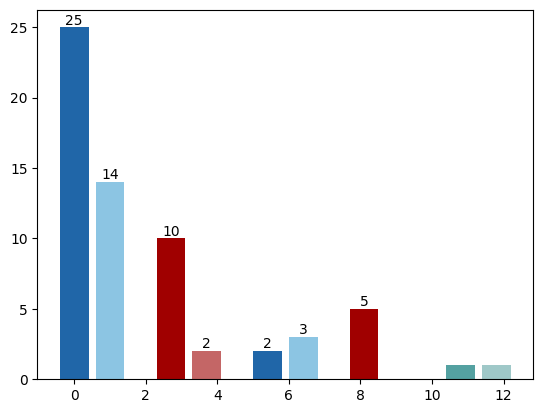

In [39]:
def plot_boards_by_family_v1(board_counts) -> None:
    # --- Prepare Data ---
    def determine_board_family_group(index: str) -> str:
        return index.split("(")[0].strip()

    df = board_counts.groupby(determine_board_family_group).sum()

    # --- Manual Sort ---
    sort_order: list[str] = [
        "Zynq US+",
        "Zynq 7000",
        "Virtex-7",
        "Virtex-6",
        "Kintex US",
        "Kintex-7",
        "Artix-7",
        "Alveo U280",
        "Cyclone V",
        "Spartan-3A",
    ]
    df = df.reindex(sort_order)

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette
    colors: list[str] = [
        "#2066a8",
        "#8cc5e3",  # Blues for Zynq US+ and Zynq 7000
        "#a00000",
        "#c46666",  # Reds for Virtex-7 and Virtex-6
        "#2066a8",
        "#8cc5e3",  # Blues again for Kintex US and Kintex-7
        "#a00000",  # Red again for Artix-7
        "#1f6f6f",
        "#54a1a1",
        "#9fc8c8",  # Teals for diverse boards
    ]

    # Define positions with gaps between groups
    positions = []
    gap = 0.7  # Define the gap size
    current_pos = 0
    for i, category in enumerate(sort_order):
        if i > 0 and category in ["Virtex-7", "Kintex US", "Artix-7", "Alveo U280"]:
            current_pos += gap
        positions.append(current_pos)
        current_pos += 1

    # Plotting
    width = 0.8  # the width of the bars
    fig, ax = plt.subplots()

    bars = ax.bar(positions, df.values, width, color=colors)

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    ax.set_title("FPGA Boards by Family")

    # Set x-ticks to the positions with the corresponding labels
    ax.set_xticks(positions)
    ax.set_xticklabels(sort_order, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks([])

    plt.show()

plot_boards_by_family_v1(datapointsDf["Board"].value_counts())